### Step 1. Load packages and data

In [42]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
import sklearn
import seaborn as sns
import datetime
import os
import time
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as r2
from math import sqrt
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 


from numpy.random import seed
seed(1)

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras import regularizers
from IPython.display import clear_output
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop

import tensorflow as tf

# import all stock prices 
df = pd.read_csv("forestfires.csv")

# Encode string data to numerical data
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

# Show the summary of data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int64  
 3   day     517 non-null    int64  
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 52.6 KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Step 2. Inspect and Pre-processing data

Text(0.5, 1.0, 'Heatmap of Bushfire features')

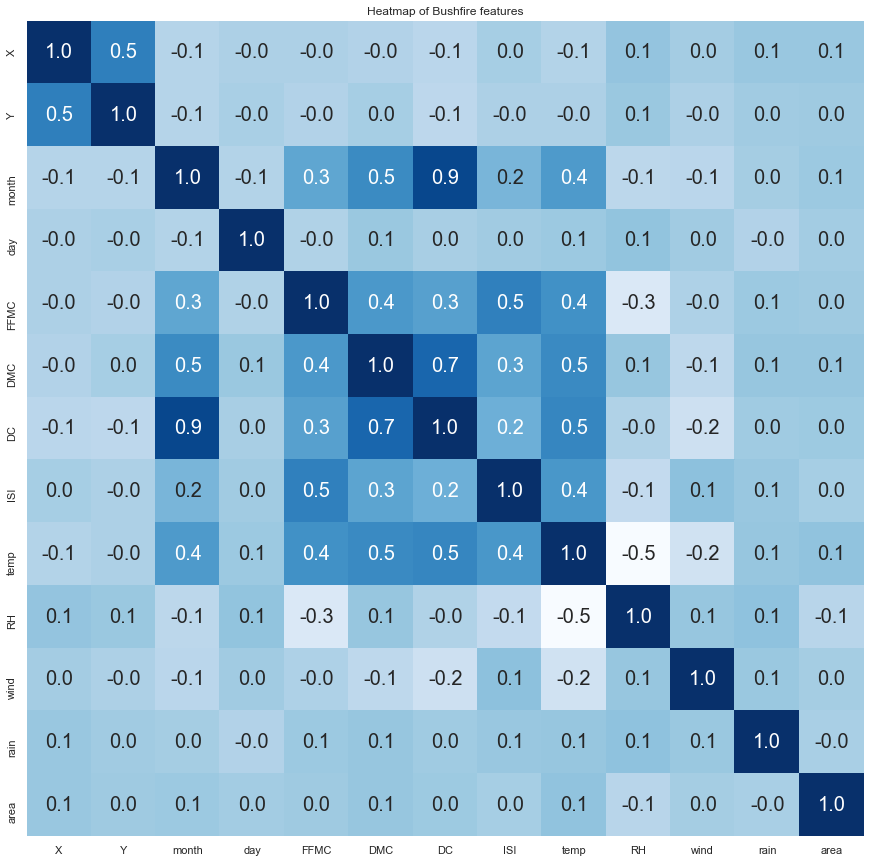

In [43]:
# Generate the heatmap.
corr = df.corr()
f,ax = plt.subplots(figsize=(15, 15))
p = sns.heatmap(corr,
                cmap='Blues',
                annot=True,
                fmt=".1f",
                annot_kws={'size':20},
                cbar=False,
                ax=ax)
sns.set(font_scale=1)
plt.title('Heatmap of Bushfire features')

D:\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

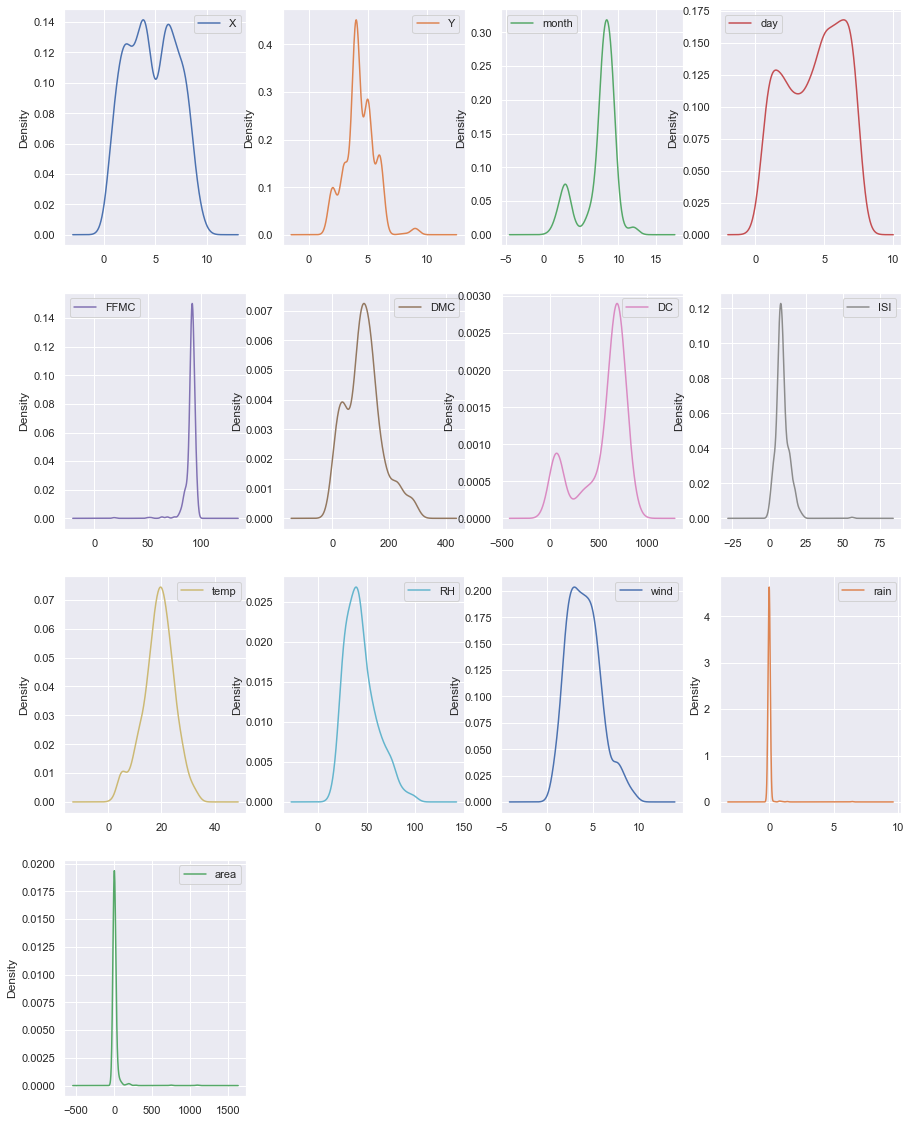

In [44]:
# check the density distribution.
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, sharey=False, ax = ax)

In [45]:
# Use one hot encoder to encode the day and month as dummy features.
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# create columns name
cols_day = ['day'+str(i+1) for i in range(7)]
cols_mon = ['mon'+str(i+1) for i in range(12)]
cols_X = ['X'+str(i+1) for i in range(9)]
cols_Y = ['Y'+str(i) for i in [2,3,4,5,6,8,9]]

# fit the data
mon_df = pd.DataFrame(OH_encoder.fit_transform(df[['month']]), columns = cols_mon)
day_df = pd.DataFrame(OH_encoder.fit_transform(df[['day']]), columns = cols_day)
X_df = pd.DataFrame(OH_encoder.fit_transform(df[['X']]), columns = cols_X)
Y_df = pd.DataFrame(OH_encoder.fit_transform(df[['Y']]), columns = cols_Y)

# Combine to a new dataframe
df = pd.concat([df, mon_df, day_df], axis=1, sort=False)
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,...,mon10,mon11,mon12,day1,day2,day3,day4,day5,day6,day7
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,7,81.6,56.7,665.6,1.9,27.8,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
513,2,4,8,7,81.6,56.7,665.6,1.9,21.9,71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
514,7,4,8,7,81.6,56.7,665.6,1.9,21.2,70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
515,1,4,8,6,94.4,146.0,614.7,11.3,25.6,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
# setup predictors and target
Y = df['area']
X = df.drop(columns=['area','month','day'])

# use logrithm transformation to convert area.
Y_log = np.log(Y.values+1)
Y = Y_log

# Normalizae the area to value from -1 to 1.
Y_n = (Y - min(Y))/(max(Y)-min(Y))*2-1

# split the data to trian validation and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_n, test_size=0.1, random_state=2)

# Normalization input feature
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)

# show the data set dimension
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)

(465, 29) (52, 29)
(465,) (52,)


D:\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Burning area distribution - logarithm')

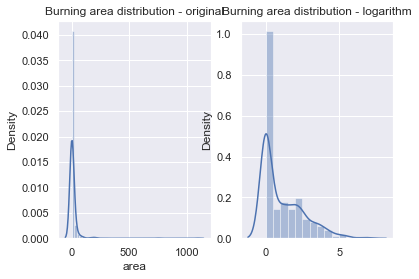

In [47]:
# The logrithm transformation for burning area
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
sns.distplot(df.area)
plt.title("Burning area distribution - original")

ax2 = fig.add_subplot(1,2,2)
sns.distplot(Y_log)
plt.title("Burning area distribution - logarithm")

### Step 3. Build ANN model for grid search

#### 3.1 grid search for primary hyper-parameters

In [ ]:
# Create a baseline model for grid search.
def create_model(init_mode='uniform', opt = 'adam', a = 32, b = 32, act = 'relu', droprate = 0.2):
    
    # kernel_regularizer=regularizers.l2(0.05)
    model = Sequential ([
        Dense(a, activation=act, input_shape=(n,),kernel_initializer=init_mode),
    #     BatchNormalization(), 
        Dropout(droprate),
        Dense(b, activation=act,kernel_initializer=init_mode),
    #     BatchNormalization(), 
        Dropout(droprate),
        Dense(1, activation='linear',kernel_initializer=init_mode),
    ])


    model.compile(optimizer=opt,
                loss='mse', metrics=['mae'])

    return model

In [ ]:
# perfrom grid search

# define number of first layer node.
n = X_train.shape[1]

# reproducible
seed = 7
np.random.seed(seed)

# fix some parameters and enable early stop to prevent overfit and reduce time cost.
batch_size = 64
epochs = 1000
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# integrate model
model_CV = KerasRegressor(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=1)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero']
opt = ['SGD','adam','RMSprop','Adadelta']
a = [8,16,32,64,128]
b = [8,16,32,64,128]
act = ['relu','tanh','selu','elu']

# start grid search and evaluate by 'neg_mean_absolute_error'.
param_grid = dict(init_mode=init_mode, opt=opt, a=a, b=b,act=act)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=10, scoring = 'neg_mean_absolute_error')
grid_result = grid.fit(X_train, Y_train, callbacks=[callback], validation_split=0.1)

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

#### 3.1.1 Result of grid search
#### Note: You can directly run this code to see the grid search result

In [7]:
# Attach the previous result.
f = open("logcv ann.txt", "r")
print(f.read())

Best Accuracy for -0.32482753506280637 using {'a': 64, 'act': 'elu', 'b': 128, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.3375, std=0.02074 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'uniform', 'opt': 'SGD'}
 mean=-0.3441, std=0.0184 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'uniform', 'opt': 'adam'}
 mean=-0.3409, std=0.0173 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'uniform', 'opt': 'RMSprop'}
 mean=-0.3444, std=0.02687 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.338, std=0.01822 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'lecun_uniform', 'opt': 'SGD'}
 mean=-0.3448, std=0.01378 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'lecun_uniform', 'opt': 'adam'}
 mean=-0.3442, std=0.02341 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'lecun_uniform', 'opt': 'RMSprop'}
 mean=-0.3482, std=0.01478 using {'a': 8, 'act': 'relu', 'b': 8, 'init_mode': 'lecun_uniform', 'opt': 'Adadelta'}
 mean=-0.3374

#### 3.2 grid search for secondary hyper-parameters

In [9]:
model_CV = KerasRegressor(build_fn=create_model, epochs=epochs, verbose=1)

# define the grid search parameters
init_mode = ['uniform']
opt = ['Adadelta']
a = [64]
b = [128]
act = ['elu']
droprate = [0.1,0.2,0.3]
batchs = [8,16,32,64]

param_grid = dict(init_mode=init_mode, opt=opt, a=a, b=b,act=act, droprate = droprate, batch_size = batchs)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=2, cv=10, scoring = 'neg_mean_absolute_error')
grid_result = grid.fit(X_train, Y_train, callbacks=[callback], validation_split=0.1)

NameError: name 'create_model' is not defined

#### 3.2.1 Result of grid search
#### Note: You can directly run this code to see the grid search result

In [10]:
# Attach the previous result.
f = open("logcv ann2.txt", "r")
print(f.read())

Best Accuracy for -0.3399704524179049 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 64, 'droprate': 0.1, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.3737, std=0.05689 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 8, 'droprate': 0.1, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.366, std=0.04005 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 8, 'droprate': 0.2, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.35, std=0.04627 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 8, 'droprate': 0.3, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.3694, std=0.04127 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 16, 'droprate': 0.1, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.3504, std=0.04886 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 16, 'droprate': 0.2, 'init_mode': 'uniform', 'opt': 'Adadelta'}
 mean=-0.3419, std=0.03262 using {'a': 64, 'act': 'elu', 'b': 128, 'batch_size': 16, 'droprate': 0.3, 'init_mode': 'uniform',

After the hyper-parameter tuning, we can build our final model now. Please refer the report for more details.

### Step 4. Final ANN model for test set.

In [48]:
# Build final ANN model

# Set up the early stop criterion.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

# reproducible
seed = 7
np.random.seed(seed)

# Define input shape
n = X_train.shape[1]

# kernel_regularizer=regularizers.l2(0.05)
model = Sequential ([
    Dense(64, activation='elu', input_shape=(n,), kernel_initializer='uniform',
#          kernel_regularizer=regularizers.l1(0.01)
         ),
#     BatchNormalization(), 
#     Dropout(0.2),
    Dense(128, activation='elu',kernel_initializer='uniform',
#           kernel_regularizer=regularizers.l1(0.01)
         ),
#     BatchNormalization(), 
#     Dropout(0.2),
    Dense(1, activation='linear',kernel_initializer='uniform'),
])
    
# Define the optimizer and loss function.   
model.compile(optimizer='Adadelta',
            loss='mse', metrics=['mae'])

# trian the ANN model
hist = model.fit(X_train, Y_train,
            batch_size=64, epochs=1000,
            validation_split=0.11,
                callbacks=[callback]
                )

Train on 413 samples, validate on 52 samples
Epoch 1/1000
413/413 [==============================] - 0s 397us/step - loss: 0.5208 - mae: 0.6517 - val_loss: 0.2991 - val_mae: 0.4718
Epoch 2/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1919 - mae: 0.3757 - val_loss: 0.1927 - val_mae: 0.3453
Epoch 3/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1659 - mae: 0.3380 - val_loss: 0.1931 - val_mae: 0.3559
Epoch 4/1000
413/413 [==============================] - 0s 27us/step - loss: 0.1674 - mae: 0.3417 - val_loss: 0.2005 - val_mae: 0.3713
Epoch 5/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1662 - mae: 0.3439 - val_loss: 0.1924 - val_mae: 0.3529
Epoch 6/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1579 - mae: 0.3318 - val_loss: 0.2124 - val_mae: 0.3461
Epoch 7/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1599 - mae: 0.3288 - val_loss: 0.1926 - val_mae: 0.3483
Epoch 8/1

Epoch 61/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1465 - mae: 0.3097 - val_loss: 0.1930 - val_mae: 0.3753
Epoch 62/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1532 - mae: 0.3276 - val_loss: 0.1896 - val_mae: 0.3385
Epoch 63/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1472 - mae: 0.3134 - val_loss: 0.1823 - val_mae: 0.3476
Epoch 64/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1515 - mae: 0.3192 - val_loss: 0.1826 - val_mae: 0.3411
Epoch 65/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1492 - mae: 0.3153 - val_loss: 0.1932 - val_mae: 0.3747
Epoch 66/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1514 - mae: 0.3262 - val_loss: 0.1951 - val_mae: 0.3386
Epoch 67/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1472 - mae: 0.3105 - val_loss: 0.1831 - val_mae: 0.3442
Epoch 68/1000
413/413 [=========================

Epoch 121/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1466 - mae: 0.3148 - val_loss: 0.1867 - val_mae: 0.3395
Epoch 122/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1461 - mae: 0.3134 - val_loss: 0.1842 - val_mae: 0.3402
Epoch 123/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1513 - mae: 0.3166 - val_loss: 0.1838 - val_mae: 0.3415
Epoch 124/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1467 - mae: 0.3147 - val_loss: 0.1911 - val_mae: 0.3398
Epoch 125/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1476 - mae: 0.3138 - val_loss: 0.1820 - val_mae: 0.3524
Epoch 126/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1492 - mae: 0.3212 - val_loss: 0.1902 - val_mae: 0.3375
Epoch 127/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1466 - mae: 0.3121 - val_loss: 0.1906 - val_mae: 0.3377
Epoch 128/1000
413/413 [=================

Epoch 240/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1473 - mae: 0.3163 - val_loss: 0.1873 - val_mae: 0.3391
Epoch 241/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1467 - mae: 0.3124 - val_loss: 0.1866 - val_mae: 0.3384
Epoch 242/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1474 - mae: 0.3126 - val_loss: 0.1811 - val_mae: 0.3418
Epoch 243/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1460 - mae: 0.3139 - val_loss: 0.1805 - val_mae: 0.3449
Epoch 244/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1478 - mae: 0.3183 - val_loss: 0.1963 - val_mae: 0.3380
Epoch 245/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1476 - mae: 0.3130 - val_loss: 0.1868 - val_mae: 0.3386
Epoch 246/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1471 - mae: 0.3114 - val_loss: 0.1820 - val_mae: 0.3400
Epoch 247/1000
413/413 [=================

Epoch 300/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1460 - mae: 0.3132 - val_loss: 0.1911 - val_mae: 0.3386
Epoch 301/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1468 - mae: 0.3101 - val_loss: 0.1797 - val_mae: 0.3440
Epoch 302/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1446 - mae: 0.3136 - val_loss: 0.1837 - val_mae: 0.3392
Epoch 303/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1490 - mae: 0.3155 - val_loss: 0.1838 - val_mae: 0.3396
Epoch 304/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1449 - mae: 0.3087 - val_loss: 0.1837 - val_mae: 0.3394
Epoch 305/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1450 - mae: 0.3110 - val_loss: 0.1805 - val_mae: 0.3399
Epoch 306/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1451 - mae: 0.3142 - val_loss: 0.1915 - val_mae: 0.3378
Epoch 307/1000
413/413 [=================

Epoch 360/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1453 - mae: 0.3102 - val_loss: 0.1830 - val_mae: 0.3401
Epoch 361/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1456 - mae: 0.3128 - val_loss: 0.1879 - val_mae: 0.3391
Epoch 362/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1447 - mae: 0.3041 - val_loss: 0.1857 - val_mae: 0.3636
Epoch 363/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1473 - mae: 0.3182 - val_loss: 0.1906 - val_mae: 0.3391
Epoch 364/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1442 - mae: 0.3068 - val_loss: 0.1804 - val_mae: 0.3420
Epoch 365/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1463 - mae: 0.3136 - val_loss: 0.1808 - val_mae: 0.3467
Epoch 366/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1444 - mae: 0.3145 - val_loss: 0.1902 - val_mae: 0.3397
Epoch 367/1000
413/413 [=================

413/413 [==============================] - 0s 22us/step - loss: 0.1457 - mae: 0.3124 - val_loss: 0.1803 - val_mae: 0.3455
Epoch 479/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1445 - mae: 0.3136 - val_loss: 0.1829 - val_mae: 0.3388
Epoch 480/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1445 - mae: 0.3114 - val_loss: 0.1854 - val_mae: 0.3380
Epoch 481/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1442 - mae: 0.3069 - val_loss: 0.1809 - val_mae: 0.3491
Epoch 482/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1465 - mae: 0.3172 - val_loss: 0.1866 - val_mae: 0.3382
Epoch 483/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1464 - mae: 0.3126 - val_loss: 0.1881 - val_mae: 0.3383
Epoch 484/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1459 - mae: 0.3109 - val_loss: 0.1816 - val_mae: 0.3393
Epoch 485/1000
413/413 [==============================] 

413/413 [==============================] - 0s 24us/step - loss: 0.1435 - mae: 0.3091 - val_loss: 0.1841 - val_mae: 0.3407
Epoch 597/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1443 - mae: 0.3102 - val_loss: 0.1830 - val_mae: 0.3420
Epoch 598/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1430 - mae: 0.3094 - val_loss: 0.1827 - val_mae: 0.3415
Epoch 599/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1433 - mae: 0.3113 - val_loss: 0.1815 - val_mae: 0.3419
Epoch 600/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1439 - mae: 0.3109 - val_loss: 0.1821 - val_mae: 0.3412
Epoch 601/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1436 - mae: 0.3104 - val_loss: 0.1816 - val_mae: 0.3426
Epoch 602/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1428 - mae: 0.3109 - val_loss: 0.1933 - val_mae: 0.3405
Epoch 603/1000
413/413 [==============================] 

Epoch 656/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1434 - mae: 0.3081 - val_loss: 0.1953 - val_mae: 0.3406
Epoch 657/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1438 - mae: 0.3064 - val_loss: 0.1842 - val_mae: 0.3421
Epoch 658/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1419 - mae: 0.3085 - val_loss: 0.1858 - val_mae: 0.3422
Epoch 659/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1409 - mae: 0.3028 - val_loss: 0.1828 - val_mae: 0.3522
Epoch 660/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1429 - mae: 0.3112 - val_loss: 0.1839 - val_mae: 0.3441
Epoch 661/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1429 - mae: 0.3095 - val_loss: 0.1857 - val_mae: 0.3423
Epoch 662/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1425 - mae: 0.3087 - val_loss: 0.1922 - val_mae: 0.3420
Epoch 663/1000
413/413 [=================

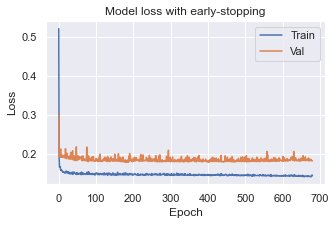

In [49]:
# Plot the train loss and val loss to see whether model converge.
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss with early-stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
# plt.ylim(0, 0.08)
# plt.savefig('./x')

fig = plt.gcf()
fig.set_size_inches(5,3)
# fig.savefig('test2png.png', dpi=1000)

#### Step 4.1. Convert normalized result back

In [50]:
# Define functions to convert normalized value back. 

# denormalize from scaled output.
def denorm(p):
    pred = ((p + 1)/2) * (max(Y)-min(Y)) + min(Y) 
    return pred

# inverse log transfer
def invlog(p):
    pred = np.exp(p)-1
    return pred

# Define a function that convert negative prediction as zero
def convert(t):
    lst = []
    t = t.tolist()
    for n in t:
        if n[0] < 0:
            n[0] = 0
            lst.append(n[0])
        else:
            lst.append(n[0])
    return lst

# Define a function that convert negative prediction as zero for cross validation
def convertcv(t):
    lst = []
    t = t.tolist()
    for n in t:
        if n < 0:
            n = 0
            lst.append(n)
        else:
            lst.append(n)
    return lst

# Define a customized MAE score function
def d_score(X_test,Y_test):
    pred = invlog(denorm(model.predict(X_test)))
    real = invlog(denorm(Y_test))
    pred_positive = convert(pred)
    score = sum(abs(pred_positive-real))/len(real)
    return score

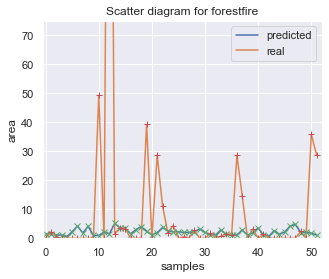

In [51]:
# plot the real value of prediction - continuous 
pred = invlog(denorm(model.predict(X_test)))
real = invlog(denorm(Y_test))
plt.plot(pred)
plt.plot(real)

# plot the real value of prediction - scatter
plt.plot(pred, format('x'))
plt.plot(real, format('+'))
plt.title("Scatter diagram for forestfire")
plt.ylabel("area")
plt.xlabel('samples')
plt.legend(['predicted', 'real'], loc='upper right')
plt.xlim(-0.5, Y_test.shape[0])
plt.ylim(0, 75)
fig = plt.gcf()
fig.set_size_inches(5,4)

In [59]:
# print MAE result for test set.
test_result = [MAE(pred,real), MSE(pred,real), sqrt(MSE(pred,real)), r2(real,pred)]
df_result_test = DataFrame(test_result).transpose()
df_result_test.columns=['MAE','MSE','RMSE','R2']
print(df_result_test)

         MAE          MSE       RMSE        R2
0  11.042602  1619.888709  40.247841 -0.053326


### Step 5. Final ANN model evaluation by using 10-fold cross validation

As suggested in assignment, the 10-fold cross validation check help us thoroughly evaluate the model performance on all data points.

In [25]:
def ANN_model(X_train,Y_train):
    # Set up the early stop criterion.
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, verbose=1)

    # Define input shape
    n = X_train.shape[1]

    # kernel_regularizer=regularizers.l2(0.05)
    model = Sequential ([
        Dense(64, activation='elu', input_shape=(n,), kernel_initializer='uniform',
#              kernel_regularizer=regularizers.l1(0.01)
             ),
    #     BatchNormalization(), 
#         Dropout(0.2),
        Dense(128, activation='elu',kernel_initializer='uniform',
#               kernel_regularizer=regularizers.l1(0.01)
             ),
    #     BatchNormalization(), 
#         Dropout(0.2),
        Dense(1, activation='linear',kernel_initializer='uniform'),
    ])

    # Define the optimizer and loss function.   
    model.compile(optimizer='Adadelta',
                loss='mse', metrics=['mae'])

    # trian the ANN model
    hist = model.fit(X_train, Y_train,
                batch_size=64, epochs=1000,
                validation_split=0.11,
                    callbacks=[callback]
                    )
    return hist, model

In [26]:
# define 10 fold test index
kfold = KFold(10, True, 99)
cv_MAE = []
cv_MSE = []
cv_RMSE = []
cv_r2 = []
cv_time = []

for train, test in kfold.split(df):
    
    # define the splited data
    X_train = X.values[train]
    y_train = Y_n[train]
    X_test = X.values[test]
    y_test = Y_n[test]
    
    # fit scaler on training data
    norm = MinMaxScaler().fit(X_train)

    # transform training data
    X_train = norm.transform(X_train)

    # transform testing dataabs
    X_test = norm.transform(X_test)
    
    # reload the package to make ANN model rebuild and start from scratch 
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers.normalization import BatchNormalization
    from keras.layers import Dropout
    from keras import regularizers
    from IPython.display import clear_output
    from keras.callbacks import EarlyStopping
    
    # start time counter.
    start_time = time.time()

    # output the model and history
    hist, model = ANN_model(X_train,y_train)
    
    # convert the prediction and test output
    pred = invlog(denorm(model.predict(X_test)))
    pred = convert(pred)
    real = invlog(denorm(y_test))
    
    # stop the counter
    elapsed_time = time.time() - start_time
    
    # update metrics
    cv_MAE.append(MAE(pred,real))
    cv_MSE.append(MSE(pred,real))
    cv_RMSE.append(sqrt(MSE(pred,real)))
    cv_r2.append(r2(real,pred))
    cv_time.append(elapsed_time)
    

D:\Anaconda3\envs\intuitive-deep-learning\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=99 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Train on 413 samples, validate on 52 samples
Epoch 1/1000
413/413 [==============================] - 0s 394us/step - loss: 0.5496 - mae: 0.6746 - val_loss: 0.2278 - val_mae: 0.4205
Epoch 2/1000
413/413 [==============================] - 0s 19us/step - loss: 0.2056 - mae: 0.3859 - val_loss: 0.2454 - val_mae: 0.3792
Epoch 3/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1699 - mae: 0.3364 - val_loss: 0.2105 - val_mae: 0.3610
Epoch 4/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1661 - mae: 0.3371 - val_loss: 0.2370 - val_mae: 0.3788
Epoch 5/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1624 - mae: 0.3316 - val_loss: 0.2623 - val_mae: 0.3962
Epoch 6/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1596 - mae: 0.3285 - val_loss: 0.2496 - val_mae: 0.3913
Epoch 7/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1555 - mae: 0.3259 - val_loss: 0.3045 - val_mae: 0.4240
Epoch 8/1

Epoch 61/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1451 - mae: 0.3059 - val_loss: 0.2731 - val_mae: 0.4141
Epoch 62/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1426 - mae: 0.3056 - val_loss: 0.3158 - val_mae: 0.4382
Epoch 63/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1469 - mae: 0.3056 - val_loss: 0.2698 - val_mae: 0.4101
Epoch 64/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1426 - mae: 0.3047 - val_loss: 0.2640 - val_mae: 0.4074
Epoch 65/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1429 - mae: 0.3011 - val_loss: 0.2231 - val_mae: 0.3853
Epoch 66/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1421 - mae: 0.3080 - val_loss: 0.3244 - val_mae: 0.4428
Epoch 67/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1487 - mae: 0.3070 - val_loss: 0.2279 - val_mae: 0.3883
Epoch 68/1000
413/413 [=========================

Epoch 121/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3054 - val_loss: 0.3362 - val_mae: 0.4478
Epoch 122/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1455 - mae: 0.3047 - val_loss: 0.2750 - val_mae: 0.4132
Epoch 123/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1447 - mae: 0.3055 - val_loss: 0.3027 - val_mae: 0.4301
Epoch 124/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1416 - mae: 0.3023 - val_loss: 0.2959 - val_mae: 0.4268
Epoch 125/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1439 - mae: 0.3036 - val_loss: 0.2292 - val_mae: 0.3896
Epoch 126/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1440 - mae: 0.3097 - val_loss: 0.3122 - val_mae: 0.4361
Epoch 127/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1445 - mae: 0.3051 - val_loss: 0.2675 - val_mae: 0.4097
Epoch 128/1000
413/413 [=================

Epoch 181/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1465 - mae: 0.3052 - val_loss: 0.2616 - val_mae: 0.4065
Epoch 182/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1426 - mae: 0.3047 - val_loss: 0.2421 - val_mae: 0.3963
Epoch 183/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1419 - mae: 0.3035 - val_loss: 0.2485 - val_mae: 0.4002
Epoch 184/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1427 - mae: 0.3051 - val_loss: 0.3096 - val_mae: 0.4341
Epoch 185/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1422 - mae: 0.3012 - val_loss: 0.2985 - val_mae: 0.4273
Epoch 186/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1432 - mae: 0.3052 - val_loss: 0.2711 - val_mae: 0.4123
Epoch 187/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1418 - mae: 0.3039 - val_loss: 0.2680 - val_mae: 0.4109
Epoch 188/1000
413/413 [=================

Epoch 241/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1430 - mae: 0.3089 - val_loss: 0.2863 - val_mae: 0.4202
Epoch 242/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1439 - mae: 0.3036 - val_loss: 0.2947 - val_mae: 0.4252
Epoch 243/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1423 - mae: 0.3031 - val_loss: 0.2968 - val_mae: 0.4263
Epoch 244/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1418 - mae: 0.3033 - val_loss: 0.3092 - val_mae: 0.4339
Epoch 245/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.2980 - val_loss: 0.2665 - val_mae: 0.4099
Epoch 246/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1410 - mae: 0.3051 - val_loss: 0.2931 - val_mae: 0.4242
Epoch 247/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1455 - mae: 0.3085 - val_loss: 0.2668 - val_mae: 0.4111
Epoch 248/1000
413/413 [=================

Epoch 360/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.3047 - val_loss: 0.2463 - val_mae: 0.4010
Epoch 361/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.3071 - val_loss: 0.2998 - val_mae: 0.4283
Epoch 362/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.2994 - val_loss: 0.2607 - val_mae: 0.4083
Epoch 363/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1438 - mae: 0.3051 - val_loss: 0.2441 - val_mae: 0.3997
Epoch 364/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3065 - val_loss: 0.2603 - val_mae: 0.4086
Epoch 365/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1417 - mae: 0.3059 - val_loss: 0.3231 - val_mae: 0.4419
Epoch 366/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1419 - mae: 0.3024 - val_loss: 0.2901 - val_mae: 0.4230
Epoch 367/1000
413/413 [=================

Epoch 420/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1422 - mae: 0.3080 - val_loss: 0.3126 - val_mae: 0.4366
Epoch 421/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1408 - mae: 0.3008 - val_loss: 0.2917 - val_mae: 0.4241
Epoch 422/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1434 - mae: 0.3048 - val_loss: 0.2863 - val_mae: 0.4207
Epoch 423/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1412 - mae: 0.3030 - val_loss: 0.2772 - val_mae: 0.4167
Epoch 424/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1406 - mae: 0.3008 - val_loss: 0.2440 - val_mae: 0.4003
Epoch 425/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1419 - mae: 0.3091 - val_loss: 0.3022 - val_mae: 0.4299
Epoch 426/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1414 - mae: 0.3014 - val_loss: 0.2729 - val_mae: 0.4146
Epoch 427/1000
413/413 [=================

Epoch 480/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1414 - mae: 0.3017 - val_loss: 0.2644 - val_mae: 0.4126
Epoch 481/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1405 - mae: 0.3024 - val_loss: 0.2886 - val_mae: 0.4227
Epoch 482/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1407 - mae: 0.3010 - val_loss: 0.2889 - val_mae: 0.4224
Epoch 483/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1428 - mae: 0.3053 - val_loss: 0.2866 - val_mae: 0.4216
Epoch 484/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1403 - mae: 0.2997 - val_loss: 0.2619 - val_mae: 0.4108
Epoch 485/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1428 - mae: 0.3053 - val_loss: 0.2934 - val_mae: 0.4248
Epoch 486/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1411 - mae: 0.2975 - val_loss: 0.2630 - val_mae: 0.4115
Epoch 487/1000
413/413 [=================

413/413 [==============================] - 0s 22us/step - loss: 0.1433 - mae: 0.3073 - val_loss: 0.1643 - val_mae: 0.3249
Epoch 91/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1438 - mae: 0.3106 - val_loss: 0.2162 - val_mae: 0.3573
Epoch 92/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1448 - mae: 0.3025 - val_loss: 0.1726 - val_mae: 0.3311
Epoch 93/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1442 - mae: 0.3066 - val_loss: 0.1873 - val_mae: 0.3406
Epoch 94/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1424 - mae: 0.3049 - val_loss: 0.1744 - val_mae: 0.3333
Epoch 95/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1423 - mae: 0.3091 - val_loss: 0.2468 - val_mae: 0.3761
Epoch 96/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1535 - mae: 0.3103 - val_loss: 0.1565 - val_mae: 0.3239
Epoch 97/1000
413/413 [==============================] - 0s 24

Epoch 150/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3051 - val_loss: 0.1876 - val_mae: 0.3389
Epoch 151/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1426 - mae: 0.3060 - val_loss: 0.1652 - val_mae: 0.3272
Epoch 152/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1425 - mae: 0.3060 - val_loss: 0.1640 - val_mae: 0.3265
Epoch 153/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1437 - mae: 0.3076 - val_loss: 0.1598 - val_mae: 0.3245
Epoch 154/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1440 - mae: 0.3083 - val_loss: 0.1671 - val_mae: 0.3276
Epoch 155/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1440 - mae: 0.3086 - val_loss: 0.1833 - val_mae: 0.3359
Epoch 156/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1420 - mae: 0.3043 - val_loss: 0.1980 - val_mae: 0.3458
Epoch 157/1000
413/413 [=================

Epoch 210/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1431 - mae: 0.3092 - val_loss: 0.1959 - val_mae: 0.3472
Epoch 211/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1413 - mae: 0.3018 - val_loss: 0.1757 - val_mae: 0.3368
Epoch 212/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1416 - mae: 0.3033 - val_loss: 0.1735 - val_mae: 0.3347
Epoch 213/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1438 - mae: 0.3085 - val_loss: 0.2208 - val_mae: 0.3614
Epoch 214/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1436 - mae: 0.3042 - val_loss: 0.1950 - val_mae: 0.3448
Epoch 215/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1417 - mae: 0.3016 - val_loss: 0.1642 - val_mae: 0.3277
Epoch 216/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1413 - mae: 0.3062 - val_loss: 0.1824 - val_mae: 0.3374
Epoch 217/1000
413/413 [=================

Epoch 329/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.3037 - val_loss: 0.1706 - val_mae: 0.3311
Epoch 330/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1411 - mae: 0.3046 - val_loss: 0.1691 - val_mae: 0.3308
Epoch 331/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1419 - mae: 0.3079 - val_loss: 0.1822 - val_mae: 0.3379
Epoch 332/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1424 - mae: 0.3044 - val_loss: 0.1630 - val_mae: 0.3269
Epoch 333/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.3072 - val_loss: 0.1895 - val_mae: 0.3418
Epoch 334/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1414 - mae: 0.3029 - val_loss: 0.1641 - val_mae: 0.3283
Epoch 335/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1448 - mae: 0.3103 - val_loss: 0.1755 - val_mae: 0.3340
Epoch 336/1000
413/413 [=================

Epoch 389/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1397 - mae: 0.2975 - val_loss: 0.1812 - val_mae: 0.3380
Epoch 390/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1435 - mae: 0.3086 - val_loss: 0.1962 - val_mae: 0.3475
Epoch 391/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1407 - mae: 0.3015 - val_loss: 0.1821 - val_mae: 0.3379
Epoch 392/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.3041 - val_loss: 0.1956 - val_mae: 0.3460
Epoch 393/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1416 - mae: 0.3055 - val_loss: 0.2082 - val_mae: 0.3520
Epoch 394/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1408 - mae: 0.3002 - val_loss: 0.1742 - val_mae: 0.3349
Epoch 395/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1411 - mae: 0.3053 - val_loss: 0.1798 - val_mae: 0.3356
Epoch 396/1000
413/413 [=================

Epoch 449/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1419 - mae: 0.3087 - val_loss: 0.1828 - val_mae: 0.3402
Epoch 450/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.3038 - val_loss: 0.1754 - val_mae: 0.3362
Epoch 451/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1396 - mae: 0.3046 - val_loss: 0.1927 - val_mae: 0.3462
Epoch 452/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1401 - mae: 0.3012 - val_loss: 0.1750 - val_mae: 0.3366
Epoch 453/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1390 - mae: 0.3024 - val_loss: 0.1762 - val_mae: 0.3371
Epoch 454/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1419 - mae: 0.3049 - val_loss: 0.1730 - val_mae: 0.3360
Epoch 455/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1398 - mae: 0.3016 - val_loss: 0.1665 - val_mae: 0.3312
Epoch 456/1000
413/413 [=================

413/413 [==============================] - 0s 19us/step - loss: 0.1427 - mae: 0.2986 - val_loss: 0.1994 - val_mae: 0.3632
Epoch 67/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1439 - mae: 0.3062 - val_loss: 0.2101 - val_mae: 0.3628
Epoch 68/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1428 - mae: 0.3022 - val_loss: 0.2302 - val_mae: 0.3719
Epoch 69/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1483 - mae: 0.3064 - val_loss: 0.2272 - val_mae: 0.3705
Epoch 70/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1433 - mae: 0.3063 - val_loss: 0.2581 - val_mae: 0.3884
Epoch 71/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1433 - mae: 0.2992 - val_loss: 0.2055 - val_mae: 0.3633
Epoch 72/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1461 - mae: 0.3069 - val_loss: 0.2132 - val_mae: 0.3648
Epoch 73/1000
413/413 [==============================] - 0s 44

413/413 [==============================] - 0s 19us/step - loss: 0.1428 - mae: 0.3038 - val_loss: 0.2420 - val_mae: 0.3792
Epoch 186/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1414 - mae: 0.3006 - val_loss: 0.2590 - val_mae: 0.3874
Epoch 187/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1446 - mae: 0.3002 - val_loss: 0.2186 - val_mae: 0.3655
Epoch 188/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1414 - mae: 0.3021 - val_loss: 0.2341 - val_mae: 0.3746
Epoch 189/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1444 - mae: 0.3045 - val_loss: 0.2765 - val_mae: 0.3965
Epoch 190/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1444 - mae: 0.3030 - val_loss: 0.2539 - val_mae: 0.3857
Epoch 191/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1441 - mae: 0.3019 - val_loss: 0.2677 - val_mae: 0.3920
Epoch 192/1000
413/413 [==============================] 

Epoch 245/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1451 - mae: 0.3040 - val_loss: 0.2204 - val_mae: 0.3664
Epoch 246/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1407 - mae: 0.3009 - val_loss: 0.2529 - val_mae: 0.3830
Epoch 247/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1423 - mae: 0.2972 - val_loss: 0.2260 - val_mae: 0.3686
Epoch 248/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1429 - mae: 0.3043 - val_loss: 0.2429 - val_mae: 0.3783
Epoch 249/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1444 - mae: 0.3036 - val_loss: 0.2665 - val_mae: 0.3908
Epoch 250/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.2969 - val_loss: 0.2287 - val_mae: 0.3706
Epoch 251/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1412 - mae: 0.3001 - val_loss: 0.2247 - val_mae: 0.3702
Epoch 252/1000
413/413 [=================

Epoch 305/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.2984 - val_loss: 0.2550 - val_mae: 0.3852
Epoch 306/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1408 - mae: 0.2967 - val_loss: 0.2087 - val_mae: 0.3657
Epoch 307/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1449 - mae: 0.3072 - val_loss: 0.2421 - val_mae: 0.3782
Epoch 308/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1423 - mae: 0.2995 - val_loss: 0.2510 - val_mae: 0.3823
Epoch 309/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.2984 - val_loss: 0.2351 - val_mae: 0.3748
Epoch 310/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1443 - mae: 0.3012 - val_loss: 0.2233 - val_mae: 0.3697
Epoch 311/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1425 - mae: 0.3028 - val_loss: 0.2421 - val_mae: 0.3786
Epoch 312/1000
413/413 [=================

Epoch 365/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1430 - mae: 0.3045 - val_loss: 0.2377 - val_mae: 0.3753
Epoch 366/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1412 - mae: 0.2998 - val_loss: 0.2133 - val_mae: 0.3660
Epoch 367/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1414 - mae: 0.3030 - val_loss: 0.2374 - val_mae: 0.3759
Epoch 368/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1430 - mae: 0.3034 - val_loss: 0.2666 - val_mae: 0.3917
Epoch 369/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1405 - mae: 0.2973 - val_loss: 0.2374 - val_mae: 0.3758
Epoch 370/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.2992 - val_loss: 0.2537 - val_mae: 0.3850
Epoch 371/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.2964 - val_loss: 0.2411 - val_mae: 0.3787
Epoch 372/1000
413/413 [=================

Epoch 425/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1421 - mae: 0.3001 - val_loss: 0.2532 - val_mae: 0.3835
Epoch 426/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.2992 - val_loss: 0.2524 - val_mae: 0.3828
Epoch 427/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1421 - mae: 0.2991 - val_loss: 0.2524 - val_mae: 0.3838
Epoch 428/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1418 - mae: 0.3000 - val_loss: 0.2756 - val_mae: 0.3968
Epoch 429/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1404 - mae: 0.2947 - val_loss: 0.2480 - val_mae: 0.3800
Epoch 430/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.2957 - val_loss: 0.2044 - val_mae: 0.3625
Epoch 431/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1445 - mae: 0.3110 - val_loss: 0.2625 - val_mae: 0.3886
Epoch 432/1000
413/413 [=================

Epoch 485/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1431 - mae: 0.2980 - val_loss: 0.2252 - val_mae: 0.3696
Epoch 486/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1406 - mae: 0.3005 - val_loss: 0.2203 - val_mae: 0.3683
Epoch 487/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1419 - mae: 0.3028 - val_loss: 0.2403 - val_mae: 0.3768
Epoch 488/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1390 - mae: 0.2952 - val_loss: 0.2132 - val_mae: 0.3664
Epoch 489/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1399 - mae: 0.3002 - val_loss: 0.2293 - val_mae: 0.3720
Epoch 490/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1410 - mae: 0.2978 - val_loss: 0.2084 - val_mae: 0.3647
Epoch 491/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1413 - mae: 0.3031 - val_loss: 0.2415 - val_mae: 0.3773
Epoch 492/1000
413/413 [=================

413/413 [==============================] - 0s 22us/step - loss: 0.1472 - mae: 0.3139 - val_loss: 0.2764 - val_mae: 0.4127
Epoch 103/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1454 - mae: 0.3057 - val_loss: 0.2562 - val_mae: 0.4010
Epoch 104/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1460 - mae: 0.3045 - val_loss: 0.2396 - val_mae: 0.3927
Epoch 105/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1443 - mae: 0.3089 - val_loss: 0.2561 - val_mae: 0.4009
Epoch 106/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1466 - mae: 0.3115 - val_loss: 0.2584 - val_mae: 0.4021
Epoch 107/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1458 - mae: 0.3071 - val_loss: 0.2999 - val_mae: 0.4248
Epoch 108/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1452 - mae: 0.3046 - val_loss: 0.2603 - val_mae: 0.4026
Epoch 109/1000
413/413 [==============================] 

Epoch 162/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1447 - mae: 0.3104 - val_loss: 0.2638 - val_mae: 0.4029
Epoch 163/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1440 - mae: 0.3056 - val_loss: 0.2542 - val_mae: 0.3986
Epoch 164/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1467 - mae: 0.3105 - val_loss: 0.2763 - val_mae: 0.4116
Epoch 165/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1461 - mae: 0.3058 - val_loss: 0.2439 - val_mae: 0.3937
Epoch 166/1000
413/413 [==============================] - ETA: 0s - loss: 0.1522 - mae: 0.327 - 0s 22us/step - loss: 0.1455 - mae: 0.3106 - val_loss: 0.2718 - val_mae: 0.4080
Epoch 167/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1443 - mae: 0.3068 - val_loss: 0.2966 - val_mae: 0.4229
Epoch 168/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1436 - mae: 0.3047 - val_loss: 0.3025 - val_mae: 0.4258
Epo

413/413 [==============================] - 0s 19us/step - loss: 0.1434 - mae: 0.3084 - val_loss: 0.2596 - val_mae: 0.4008
Epoch 281/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1450 - mae: 0.3068 - val_loss: 0.2391 - val_mae: 0.3911
Epoch 282/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1437 - mae: 0.3092 - val_loss: 0.2724 - val_mae: 0.4088
Epoch 283/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1451 - mae: 0.3067 - val_loss: 0.2798 - val_mae: 0.4136
Epoch 284/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1423 - mae: 0.2984 - val_loss: 0.2286 - val_mae: 0.3876
Epoch 285/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1497 - mae: 0.3160 - val_loss: 0.2306 - val_mae: 0.3889
Epoch 286/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1444 - mae: 0.3102 - val_loss: 0.2720 - val_mae: 0.4088
Epoch 287/1000
413/413 [==============================] 

Epoch 340/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1458 - mae: 0.3071 - val_loss: 0.2320 - val_mae: 0.3869
Epoch 341/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1451 - mae: 0.3135 - val_loss: 0.2530 - val_mae: 0.3986
Epoch 342/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1446 - mae: 0.3067 - val_loss: 0.2527 - val_mae: 0.3984
Epoch 343/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1439 - mae: 0.3071 - val_loss: 0.2533 - val_mae: 0.4002
Epoch 344/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1442 - mae: 0.3087 - val_loss: 0.2825 - val_mae: 0.4159
Epoch 345/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1433 - mae: 0.3054 - val_loss: 0.3044 - val_mae: 0.4282
Epoch 346/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1438 - mae: 0.3048 - val_loss: 0.3175 - val_mae: 0.4340
Epoch 347/1000
413/413 [=================

Epoch 400/1000
413/413 [==============================] - 0s 31us/step - loss: 0.1441 - mae: 0.3045 - val_loss: 0.2746 - val_mae: 0.4101
Epoch 401/1000
413/413 [==============================] - 0s 31us/step - loss: 0.1453 - mae: 0.3067 - val_loss: 0.2520 - val_mae: 0.3987
Epoch 402/1000
413/413 [==============================] - 0s 27us/step - loss: 0.1461 - mae: 0.3092 - val_loss: 0.2610 - val_mae: 0.4039
Epoch 403/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1449 - mae: 0.3042 - val_loss: 0.2600 - val_mae: 0.4035
Epoch 404/1000
413/413 [==============================] - 0s 29us/step - loss: 0.1438 - mae: 0.3046 - val_loss: 0.2521 - val_mae: 0.4004
Epoch 405/1000
413/413 [==============================] - 0s 27us/step - loss: 0.1451 - mae: 0.3083 - val_loss: 0.2642 - val_mae: 0.4052
Epoch 406/1000
413/413 [==============================] - 0s 29us/step - loss: 0.1436 - mae: 0.3066 - val_loss: 0.2694 - val_mae: 0.4077
Epoch 407/1000
413/413 [=================

Epoch 460/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1422 - mae: 0.3064 - val_loss: 0.2827 - val_mae: 0.4153
Epoch 461/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1429 - mae: 0.3039 - val_loss: 0.2574 - val_mae: 0.4015
Epoch 462/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1432 - mae: 0.3073 - val_loss: 0.2591 - val_mae: 0.4017
Epoch 463/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1420 - mae: 0.3046 - val_loss: 0.2541 - val_mae: 0.4004
Epoch 464/1000
413/413 [==============================] - 0s 29us/step - loss: 0.1426 - mae: 0.3070 - val_loss: 0.2878 - val_mae: 0.4179
Epoch 465/1000
413/413 [==============================] - 0s 27us/step - loss: 0.1425 - mae: 0.3013 - val_loss: 0.2661 - val_mae: 0.4062
Epoch 466/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1432 - mae: 0.3061 - val_loss: 0.2632 - val_mae: 0.4065
Epoch 467/1000
413/413 [=================

413/413 [==============================] - 0s 22us/step - loss: 0.1472 - mae: 0.3073 - val_loss: 0.2448 - val_mae: 0.3806
Epoch 77/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1446 - mae: 0.3059 - val_loss: 0.2482 - val_mae: 0.3821
Epoch 78/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1456 - mae: 0.3075 - val_loss: 0.2718 - val_mae: 0.3958
Epoch 79/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1441 - mae: 0.3051 - val_loss: 0.2843 - val_mae: 0.4038
Epoch 80/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1467 - mae: 0.3075 - val_loss: 0.2315 - val_mae: 0.3716
Epoch 81/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1439 - mae: 0.3075 - val_loss: 0.2749 - val_mae: 0.3980
Epoch 82/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1473 - mae: 0.3089 - val_loss: 0.2214 - val_mae: 0.3663
Epoch 83/1000
413/413 [==============================] - 0s 19

413/413 [==============================] - 0s 19us/step - loss: 0.1431 - mae: 0.3056 - val_loss: 0.2884 - val_mae: 0.4059
Epoch 137/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1439 - mae: 0.3040 - val_loss: 0.2520 - val_mae: 0.3839
Epoch 138/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1433 - mae: 0.3069 - val_loss: 0.2588 - val_mae: 0.3884
Epoch 139/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1436 - mae: 0.3043 - val_loss: 0.2446 - val_mae: 0.3789
Epoch 140/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1446 - mae: 0.3072 - val_loss: 0.2509 - val_mae: 0.3833
Epoch 141/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1434 - mae: 0.3047 - val_loss: 0.2346 - val_mae: 0.3727
Epoch 142/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1450 - mae: 0.3085 - val_loss: 0.2341 - val_mae: 0.3723
Epoch 143/1000
413/413 [==============================] 

413/413 [==============================] - 0s 22us/step - loss: 0.1450 - mae: 0.3027 - val_loss: 0.2051 - val_mae: 0.3553
Epoch 255/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1460 - mae: 0.3116 - val_loss: 0.2091 - val_mae: 0.3581
Epoch 256/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1445 - mae: 0.3092 - val_loss: 0.2222 - val_mae: 0.3665
Epoch 257/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1455 - mae: 0.3079 - val_loss: 0.2455 - val_mae: 0.3794
Epoch 258/1000
413/413 [==============================] - 0s 46us/step - loss: 0.1432 - mae: 0.3053 - val_loss: 0.2553 - val_mae: 0.3859
Epoch 259/1000
413/413 [==============================] - 0s 24us/step - loss: 0.1420 - mae: 0.3024 - val_loss: 0.2207 - val_mae: 0.3671
Epoch 260/1000
413/413 [==============================] - 0s 27us/step - loss: 0.1424 - mae: 0.3047 - val_loss: 0.2111 - val_mae: 0.3607
Epoch 261/1000
413/413 [==============================] 

Epoch 373/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1430 - mae: 0.3046 - val_loss: 0.2328 - val_mae: 0.3722
Epoch 374/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1462 - mae: 0.3075 - val_loss: 0.2241 - val_mae: 0.3672
Epoch 375/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1423 - mae: 0.3067 - val_loss: 0.2545 - val_mae: 0.3844
Epoch 376/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1415 - mae: 0.3003 - val_loss: 0.2291 - val_mae: 0.3710
Epoch 377/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3056 - val_loss: 0.2409 - val_mae: 0.3777
Epoch 378/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3055 - val_loss: 0.2793 - val_mae: 0.3999
Epoch 379/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1414 - mae: 0.3008 - val_loss: 0.2786 - val_mae: 0.3998
Epoch 380/1000
413/413 [=================

Epoch 433/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1420 - mae: 0.3076 - val_loss: 0.2479 - val_mae: 0.3806
Epoch 434/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1452 - mae: 0.3025 - val_loss: 0.2346 - val_mae: 0.3735
Epoch 435/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1416 - mae: 0.3067 - val_loss: 0.2559 - val_mae: 0.3848
Epoch 436/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1412 - mae: 0.3027 - val_loss: 0.2572 - val_mae: 0.3860
Epoch 437/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1434 - mae: 0.3081 - val_loss: 0.3015 - val_mae: 0.4109
Epoch 438/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1437 - mae: 0.3014 - val_loss: 0.2505 - val_mae: 0.3814
Epoch 439/1000
413/413 [==============================] - 0s 27us/step - loss: 0.1429 - mae: 0.3035 - val_loss: 0.2616 - val_mae: 0.3880
Epoch 440/1000
413/413 [=================

Epoch 493/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1425 - mae: 0.3047 - val_loss: 0.2724 - val_mae: 0.3955
Epoch 494/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.3018 - val_loss: 0.2543 - val_mae: 0.3854
Epoch 495/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1427 - mae: 0.3039 - val_loss: 0.2713 - val_mae: 0.3945
Epoch 496/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1442 - mae: 0.3048 - val_loss: 0.2592 - val_mae: 0.3880
Epoch 497/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.3020 - val_loss: 0.2566 - val_mae: 0.3866
Epoch 498/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1414 - mae: 0.3011 - val_loss: 0.2158 - val_mae: 0.3643
Epoch 499/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.3091 - val_loss: 0.2723 - val_mae: 0.3960
Epoch 500/1000
413/413 [=================

413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3113 - val_loss: 0.2249 - val_mae: 0.3683
Epoch 109/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1413 - mae: 0.3079 - val_loss: 0.2410 - val_mae: 0.3764
Epoch 110/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1469 - mae: 0.3087 - val_loss: 0.2023 - val_mae: 0.3593
Epoch 111/1000
413/413 [==============================] - ETA: 0s - loss: 0.1545 - mae: 0.349 - 0s 19us/step - loss: 0.1451 - mae: 0.3151 - val_loss: 0.2154 - val_mae: 0.3637
Epoch 112/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1401 - mae: 0.3080 - val_loss: 0.2281 - val_mae: 0.3707
Epoch 113/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.3054 - val_loss: 0.2202 - val_mae: 0.3666
Epoch 114/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1407 - mae: 0.3038 - val_loss: 0.2022 - val_mae: 0.3590
Epoch 115/1000
413

Epoch 227/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1450 - mae: 0.3100 - val_loss: 0.2026 - val_mae: 0.3596
Epoch 228/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1414 - mae: 0.3109 - val_loss: 0.2167 - val_mae: 0.3647
Epoch 229/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1414 - mae: 0.3072 - val_loss: 0.2262 - val_mae: 0.3701
Epoch 230/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1409 - mae: 0.3063 - val_loss: 0.2282 - val_mae: 0.3716
Epoch 231/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1400 - mae: 0.3080 - val_loss: 0.2645 - val_mae: 0.3872
Epoch 232/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1420 - mae: 0.3024 - val_loss: 0.2155 - val_mae: 0.3657
Epoch 233/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.3099 - val_loss: 0.2379 - val_mae: 0.3760
Epoch 234/1000
413/413 [=================

Epoch 287/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1406 - mae: 0.3069 - val_loss: 0.2206 - val_mae: 0.3672
Epoch 288/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1410 - mae: 0.3086 - val_loss: 0.2275 - val_mae: 0.3716
Epoch 289/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1420 - mae: 0.3078 - val_loss: 0.2115 - val_mae: 0.3637
Epoch 290/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1418 - mae: 0.3095 - val_loss: 0.2351 - val_mae: 0.3755
Epoch 291/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1396 - mae: 0.3017 - val_loss: 0.2106 - val_mae: 0.3631
Epoch 292/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1419 - mae: 0.3097 - val_loss: 0.2234 - val_mae: 0.3685
Epoch 293/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1399 - mae: 0.3024 - val_loss: 0.2121 - val_mae: 0.3627
Epoch 294/1000
413/413 [=================

Epoch 347/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1389 - mae: 0.3070 - val_loss: 0.2401 - val_mae: 0.3756
Epoch 348/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1402 - mae: 0.3058 - val_loss: 0.2340 - val_mae: 0.3729
Epoch 349/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1388 - mae: 0.3028 - val_loss: 0.2133 - val_mae: 0.3636
Epoch 350/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.3078 - val_loss: 0.2290 - val_mae: 0.3707
Epoch 351/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1406 - mae: 0.3051 - val_loss: 0.2077 - val_mae: 0.3601
Epoch 352/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1406 - mae: 0.3081 - val_loss: 0.2020 - val_mae: 0.3581
Epoch 353/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1398 - mae: 0.3100 - val_loss: 0.2483 - val_mae: 0.3785
Epoch 354/1000
413/413 [=================

Epoch 407/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1391 - mae: 0.3073 - val_loss: 0.2555 - val_mae: 0.3829
Epoch 408/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1395 - mae: 0.3027 - val_loss: 0.2181 - val_mae: 0.3667
Epoch 409/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1395 - mae: 0.3036 - val_loss: 0.2151 - val_mae: 0.3643
Epoch 410/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1398 - mae: 0.3077 - val_loss: 0.2481 - val_mae: 0.3789
Epoch 411/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1416 - mae: 0.3030 - val_loss: 0.2145 - val_mae: 0.3643
Epoch 412/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1391 - mae: 0.3050 - val_loss: 0.2202 - val_mae: 0.3663
Epoch 413/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1399 - mae: 0.3034 - val_loss: 0.2081 - val_mae: 0.3615
Epoch 414/1000
413/413 [=================

413/413 [==============================] - 0s 19us/step - loss: 0.1522 - mae: 0.3113 - val_loss: 0.2122 - val_mae: 0.3665
Epoch 23/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1486 - mae: 0.3076 - val_loss: 0.2448 - val_mae: 0.3896
Epoch 24/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1464 - mae: 0.3058 - val_loss: 0.3040 - val_mae: 0.4227
Epoch 25/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1528 - mae: 0.3092 - val_loss: 0.2702 - val_mae: 0.4049
Epoch 26/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1448 - mae: 0.3018 - val_loss: 0.2652 - val_mae: 0.4020
Epoch 27/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1476 - mae: 0.3055 - val_loss: 0.1991 - val_mae: 0.3601
Epoch 28/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1468 - mae: 0.3133 - val_loss: 0.2360 - val_mae: 0.3847
Epoch 29/1000
413/413 [==============================] - 0s 22

413/413 [==============================] - 0s 22us/step - loss: 0.1493 - mae: 0.3119 - val_loss: 0.2913 - val_mae: 0.4150
Epoch 142/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1453 - mae: 0.3025 - val_loss: 0.2727 - val_mae: 0.4044
Epoch 143/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1441 - mae: 0.3032 - val_loss: 0.2603 - val_mae: 0.3965
Epoch 144/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1434 - mae: 0.3037 - val_loss: 0.2921 - val_mae: 0.4149
Epoch 145/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1438 - mae: 0.2990 - val_loss: 0.2335 - val_mae: 0.3818
Epoch 146/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1449 - mae: 0.3033 - val_loss: 0.2232 - val_mae: 0.3767
Epoch 147/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1447 - mae: 0.3063 - val_loss: 0.2750 - val_mae: 0.4068
Epoch 148/1000
413/413 [==============================] 

Epoch 201/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1429 - mae: 0.3007 - val_loss: 0.2357 - val_mae: 0.3823
Epoch 202/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1416 - mae: 0.3009 - val_loss: 0.2330 - val_mae: 0.3828
Epoch 203/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1419 - mae: 0.3030 - val_loss: 0.2589 - val_mae: 0.3980
Epoch 204/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1462 - mae: 0.3037 - val_loss: 0.2370 - val_mae: 0.3849
Epoch 205/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1446 - mae: 0.3038 - val_loss: 0.2442 - val_mae: 0.3892
Epoch 206/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1438 - mae: 0.3031 - val_loss: 0.2498 - val_mae: 0.3925
Epoch 207/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1424 - mae: 0.3021 - val_loss: 0.2462 - val_mae: 0.3908
Epoch 208/1000
413/413 [=================

Epoch 261/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1429 - mae: 0.3023 - val_loss: 0.2648 - val_mae: 0.3997
Epoch 262/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1416 - mae: 0.3005 - val_loss: 0.2548 - val_mae: 0.3936
Epoch 263/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1431 - mae: 0.3032 - val_loss: 0.2328 - val_mae: 0.3824
Epoch 264/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.3036 - val_loss: 0.2828 - val_mae: 0.4106
Epoch 265/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1442 - mae: 0.3010 - val_loss: 0.2499 - val_mae: 0.3913
Epoch 266/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1409 - mae: 0.2964 - val_loss: 0.2068 - val_mae: 0.3713
Epoch 267/1000
413/413 [==============================] - 0s 17us/step - loss: 0.1489 - mae: 0.3179 - val_loss: 0.2342 - val_mae: 0.3832
Epoch 268/1000
413/413 [=================

Epoch 380/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1425 - mae: 0.2987 - val_loss: 0.2404 - val_mae: 0.3874
Epoch 381/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3029 - val_loss: 0.2469 - val_mae: 0.3913
Epoch 382/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1415 - mae: 0.3015 - val_loss: 0.2475 - val_mae: 0.3918
Epoch 383/1000
413/413 [==============================] - ETA: 0s - loss: 0.1319 - mae: 0.314 - 0s 19us/step - loss: 0.1421 - mae: 0.3046 - val_loss: 0.3048 - val_mae: 0.4238
Epoch 384/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1435 - mae: 0.2980 - val_loss: 0.2533 - val_mae: 0.3938
Epoch 385/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1438 - mae: 0.3041 - val_loss: 0.2813 - val_mae: 0.4102
Epoch 386/1000
413/413 [==============================] - 0s 22us/step - loss: 0.1418 - mae: 0.2962 - val_loss: 0.2380 - val_mae: 0.3859
Epo

Epoch 499/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1426 - mae: 0.3009 - val_loss: 0.2689 - val_mae: 0.4032
Epoch 500/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1415 - mae: 0.2979 - val_loss: 0.2518 - val_mae: 0.3936
Epoch 501/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1405 - mae: 0.2980 - val_loss: 0.2348 - val_mae: 0.3848
Epoch 502/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1418 - mae: 0.3031 - val_loss: 0.2629 - val_mae: 0.4002
Epoch 503/1000
413/413 [==============================] - 0s 19us/step - loss: 0.1409 - mae: 0.2989 - val_loss: 0.2747 - val_mae: 0.4073
Epoch 00503: early stopping
Train on 414 samples, validate on 52 samples
Epoch 1/1000
414/414 [==============================] - 0s 388us/step - loss: 0.5260 - mae: 0.6568 - val_loss: 0.1935 - val_mae: 0.3801
Epoch 2/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1928 - mae: 0.3696 - val_lo

Epoch 115/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1427 - mae: 0.3011 - val_loss: 0.2099 - val_mae: 0.3795
Epoch 116/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1456 - mae: 0.3085 - val_loss: 0.2334 - val_mae: 0.3887
Epoch 117/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1426 - mae: 0.3027 - val_loss: 0.2263 - val_mae: 0.3854
Epoch 118/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1442 - mae: 0.3064 - val_loss: 0.2237 - val_mae: 0.3841
Epoch 119/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1448 - mae: 0.3061 - val_loss: 0.2209 - val_mae: 0.3825
Epoch 120/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1471 - mae: 0.3110 - val_loss: 0.2652 - val_mae: 0.4045
Epoch 121/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1460 - mae: 0.3073 - val_loss: 0.3011 - val_mae: 0.4201
Epoch 122/1000
414/414 [=================

Epoch 175/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1437 - mae: 0.3009 - val_loss: 0.2352 - val_mae: 0.3924
Epoch 176/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1447 - mae: 0.3048 - val_loss: 0.2363 - val_mae: 0.3927
Epoch 177/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1474 - mae: 0.3095 - val_loss: 0.2391 - val_mae: 0.3944
Epoch 178/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1420 - mae: 0.3005 - val_loss: 0.2478 - val_mae: 0.3975
Epoch 179/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.3010 - val_loss: 0.2220 - val_mae: 0.3883
Epoch 180/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1462 - mae: 0.3092 - val_loss: 0.2415 - val_mae: 0.3966
Epoch 181/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1494 - mae: 0.3099 - val_loss: 0.2380 - val_mae: 0.3937
Epoch 182/1000
414/414 [=================

Epoch 235/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1448 - mae: 0.2988 - val_loss: 0.2325 - val_mae: 0.3903
Epoch 236/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1450 - mae: 0.3076 - val_loss: 0.2597 - val_mae: 0.4049
Epoch 237/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.2989 - val_loss: 0.2288 - val_mae: 0.3896
Epoch 238/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1424 - mae: 0.3041 - val_loss: 0.2370 - val_mae: 0.3926
Epoch 239/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1413 - mae: 0.3040 - val_loss: 0.2957 - val_mae: 0.4210
Epoch 240/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1410 - mae: 0.2942 - val_loss: 0.2406 - val_mae: 0.3954
Epoch 241/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1465 - mae: 0.3076 - val_loss: 0.2401 - val_mae: 0.3944
Epoch 242/1000
414/414 [=================

Epoch 295/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1419 - mae: 0.3010 - val_loss: 0.2919 - val_mae: 0.4187
Epoch 296/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1419 - mae: 0.2979 - val_loss: 0.2224 - val_mae: 0.3873
Epoch 297/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1447 - mae: 0.3057 - val_loss: 0.2507 - val_mae: 0.3992
Epoch 298/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1432 - mae: 0.3039 - val_loss: 0.2569 - val_mae: 0.4013
Epoch 299/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1423 - mae: 0.3006 - val_loss: 0.2309 - val_mae: 0.3896
Epoch 300/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1409 - mae: 0.3042 - val_loss: 0.2459 - val_mae: 0.3973
Epoch 301/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.3027 - val_loss: 0.2441 - val_mae: 0.3978
Epoch 302/1000
414/414 [=================

Epoch 355/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1422 - mae: 0.3026 - val_loss: 0.2617 - val_mae: 0.4057
Epoch 356/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.3007 - val_loss: 0.2681 - val_mae: 0.4091
Epoch 357/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.2974 - val_loss: 0.2479 - val_mae: 0.3974
Epoch 358/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1420 - mae: 0.3010 - val_loss: 0.2560 - val_mae: 0.4018
Epoch 359/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1445 - mae: 0.3036 - val_loss: 0.2673 - val_mae: 0.4078
Epoch 360/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1442 - mae: 0.3032 - val_loss: 0.2678 - val_mae: 0.4082
Epoch 361/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1420 - mae: 0.3003 - val_loss: 0.2852 - val_mae: 0.4151
Epoch 362/1000
414/414 [=================

Epoch 415/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1419 - mae: 0.3043 - val_loss: 0.2865 - val_mae: 0.4191
Epoch 416/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1424 - mae: 0.3004 - val_loss: 0.2573 - val_mae: 0.4045
Epoch 417/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1418 - mae: 0.3018 - val_loss: 0.2874 - val_mae: 0.4194
Epoch 418/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1413 - mae: 0.2990 - val_loss: 0.2532 - val_mae: 0.4025
Epoch 419/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1422 - mae: 0.2979 - val_loss: 0.2247 - val_mae: 0.3899
Epoch 420/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1412 - mae: 0.3046 - val_loss: 0.2624 - val_mae: 0.4060
Epoch 421/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1440 - mae: 0.3032 - val_loss: 0.2590 - val_mae: 0.4041
Epoch 422/1000
414/414 [=================

Epoch 475/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1420 - mae: 0.3016 - val_loss: 0.2622 - val_mae: 0.4068
Epoch 476/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1428 - mae: 0.3022 - val_loss: 0.2495 - val_mae: 0.3996
Epoch 477/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1410 - mae: 0.3016 - val_loss: 0.2793 - val_mae: 0.4148
Epoch 478/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1448 - mae: 0.3034 - val_loss: 0.2365 - val_mae: 0.3939
Epoch 479/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1453 - mae: 0.3092 - val_loss: 0.2542 - val_mae: 0.4013
Epoch 480/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1410 - mae: 0.3000 - val_loss: 0.2362 - val_mae: 0.3929
Epoch 481/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1419 - mae: 0.3057 - val_loss: 0.2659 - val_mae: 0.4085
Epoch 482/1000
414/414 [=================

414/414 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.3034 - val_loss: 0.2159 - val_mae: 0.3798
Epoch 91/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1447 - mae: 0.3122 - val_loss: 0.2218 - val_mae: 0.3824
Epoch 92/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1425 - mae: 0.3095 - val_loss: 0.2415 - val_mae: 0.3943
Epoch 93/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1424 - mae: 0.3047 - val_loss: 0.2194 - val_mae: 0.3823
Epoch 94/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1454 - mae: 0.3130 - val_loss: 0.2285 - val_mae: 0.3874
Epoch 95/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1429 - mae: 0.3039 - val_loss: 0.2317 - val_mae: 0.3881
Epoch 96/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1487 - mae: 0.3154 - val_loss: 0.2645 - val_mae: 0.4042
Epoch 97/1000
414/414 [==============================] - 0s 22

Epoch 150/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1416 - mae: 0.3053 - val_loss: 0.2477 - val_mae: 0.3966
Epoch 151/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1419 - mae: 0.3068 - val_loss: 0.2454 - val_mae: 0.3952
Epoch 152/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1423 - mae: 0.3060 - val_loss: 0.2591 - val_mae: 0.4012
Epoch 153/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1428 - mae: 0.3061 - val_loss: 0.2498 - val_mae: 0.3962
Epoch 154/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1418 - mae: 0.3072 - val_loss: 0.2603 - val_mae: 0.4008
Epoch 155/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1433 - mae: 0.3062 - val_loss: 0.2606 - val_mae: 0.4008
Epoch 156/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1459 - mae: 0.3065 - val_loss: 0.2672 - val_mae: 0.4056
Epoch 157/1000
414/414 [=================

Epoch 269/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1409 - mae: 0.3062 - val_loss: 0.2618 - val_mae: 0.4058
Epoch 270/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1406 - mae: 0.3031 - val_loss: 0.2787 - val_mae: 0.4143
Epoch 271/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1434 - mae: 0.3027 - val_loss: 0.2314 - val_mae: 0.3892
Epoch 272/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1417 - mae: 0.3090 - val_loss: 0.2688 - val_mae: 0.4089
Epoch 273/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1413 - mae: 0.3034 - val_loss: 0.2396 - val_mae: 0.3947
Epoch 274/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1442 - mae: 0.3102 - val_loss: 0.2532 - val_mae: 0.4024
Epoch 275/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1399 - mae: 0.3025 - val_loss: 0.2336 - val_mae: 0.3909
Epoch 276/1000
414/414 [=================

Epoch 329/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1410 - mae: 0.3013 - val_loss: 0.2636 - val_mae: 0.4056
Epoch 330/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.3048 - val_loss: 0.2624 - val_mae: 0.4052
Epoch 331/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1417 - mae: 0.3018 - val_loss: 0.2353 - val_mae: 0.3903
Epoch 332/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1430 - mae: 0.3103 - val_loss: 0.2502 - val_mae: 0.3981
Epoch 333/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1424 - mae: 0.3043 - val_loss: 0.2197 - val_mae: 0.3832
Epoch 334/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1428 - mae: 0.3089 - val_loss: 0.2670 - val_mae: 0.4077
Epoch 335/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1405 - mae: 0.3034 - val_loss: 0.2467 - val_mae: 0.3974
Epoch 336/1000
414/414 [=================

Epoch 389/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1408 - mae: 0.3067 - val_loss: 0.2691 - val_mae: 0.4102
Epoch 390/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1402 - mae: 0.3033 - val_loss: 0.2591 - val_mae: 0.4046
Epoch 391/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1423 - mae: 0.3043 - val_loss: 0.2535 - val_mae: 0.4010
Epoch 392/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1409 - mae: 0.3049 - val_loss: 0.2383 - val_mae: 0.3936
Epoch 393/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.3058 - val_loss: 0.2297 - val_mae: 0.3888
Epoch 394/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.3081 - val_loss: 0.2525 - val_mae: 0.4001
Epoch 395/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1409 - mae: 0.3035 - val_loss: 0.2392 - val_mae: 0.3936
Epoch 396/1000
414/414 [=================

Epoch 449/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1407 - mae: 0.3043 - val_loss: 0.2564 - val_mae: 0.4048
Epoch 450/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1401 - mae: 0.3055 - val_loss: 0.2792 - val_mae: 0.4158
Epoch 451/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1403 - mae: 0.3015 - val_loss: 0.2487 - val_mae: 0.4007
Epoch 452/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1412 - mae: 0.3044 - val_loss: 0.2468 - val_mae: 0.4002
Epoch 453/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1397 - mae: 0.3046 - val_loss: 0.2551 - val_mae: 0.4049
Epoch 454/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1407 - mae: 0.3044 - val_loss: 0.2359 - val_mae: 0.3941
Epoch 455/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1414 - mae: 0.3079 - val_loss: 0.2752 - val_mae: 0.4132
Epoch 456/1000
414/414 [=================

414/414 [==============================] - 0s 19us/step - loss: 0.1425 - mae: 0.3097 - val_loss: 0.2696 - val_mae: 0.4020
Epoch 65/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.3016 - val_loss: 0.2835 - val_mae: 0.4094
Epoch 66/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1431 - mae: 0.3021 - val_loss: 0.2486 - val_mae: 0.3893
Epoch 67/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1460 - mae: 0.3054 - val_loss: 0.2503 - val_mae: 0.3907
Epoch 68/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1411 - mae: 0.3032 - val_loss: 0.2232 - val_mae: 0.3738
Epoch 69/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1440 - mae: 0.3052 - val_loss: 0.2088 - val_mae: 0.3628
Epoch 70/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1421 - mae: 0.3047 - val_loss: 0.2035 - val_mae: 0.3595
Epoch 71/1000
414/414 [==============================] - 0s 19

414/414 [==============================] - 0s 19us/step - loss: 0.1392 - mae: 0.3027 - val_loss: 0.2611 - val_mae: 0.3961
Epoch 184/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1454 - mae: 0.3078 - val_loss: 0.2431 - val_mae: 0.3862
Epoch 185/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1393 - mae: 0.2999 - val_loss: 0.2154 - val_mae: 0.3689
Epoch 186/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1398 - mae: 0.3051 - val_loss: 0.2351 - val_mae: 0.3824
Epoch 187/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1398 - mae: 0.3022 - val_loss: 0.2422 - val_mae: 0.3866
Epoch 188/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1383 - mae: 0.3023 - val_loss: 0.3063 - val_mae: 0.4208
Epoch 189/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1447 - mae: 0.3055 - val_loss: 0.2868 - val_mae: 0.4111
Epoch 190/1000
414/414 [==============================] 

Epoch 243/1000
414/414 [==============================] - 0s 24us/step - loss: 0.1409 - mae: 0.3057 - val_loss: 0.3027 - val_mae: 0.4175
Epoch 244/1000
414/414 [==============================] - 0s 24us/step - loss: 0.1446 - mae: 0.2981 - val_loss: 0.2102 - val_mae: 0.3639
Epoch 245/1000
414/414 [==============================] - 0s 24us/step - loss: 0.1392 - mae: 0.3067 - val_loss: 0.2573 - val_mae: 0.3943
Epoch 246/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1421 - mae: 0.3009 - val_loss: 0.2084 - val_mae: 0.3623
Epoch 247/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1409 - mae: 0.3081 - val_loss: 0.2742 - val_mae: 0.4030
Epoch 248/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1395 - mae: 0.2963 - val_loss: 0.2334 - val_mae: 0.3797
Epoch 249/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1392 - mae: 0.3029 - val_loss: 0.2563 - val_mae: 0.3930
Epoch 250/1000
414/414 [=================

Epoch 303/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1393 - mae: 0.3035 - val_loss: 0.2542 - val_mae: 0.3928
Epoch 304/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1395 - mae: 0.2980 - val_loss: 0.2275 - val_mae: 0.3764
Epoch 305/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1394 - mae: 0.3030 - val_loss: 0.2637 - val_mae: 0.3980
Epoch 306/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1403 - mae: 0.2993 - val_loss: 0.2239 - val_mae: 0.3743
Epoch 307/1000
414/414 [==============================] - 0s 27us/step - loss: 0.1395 - mae: 0.3035 - val_loss: 0.2649 - val_mae: 0.3987
Epoch 308/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1411 - mae: 0.2998 - val_loss: 0.2159 - val_mae: 0.3683
Epoch 309/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1399 - mae: 0.3044 - val_loss: 0.2551 - val_mae: 0.3933
Epoch 310/1000
414/414 [=================

Epoch 363/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1413 - mae: 0.2995 - val_loss: 0.2267 - val_mae: 0.3767
Epoch 364/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1391 - mae: 0.3020 - val_loss: 0.2217 - val_mae: 0.3735
Epoch 365/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1391 - mae: 0.2973 - val_loss: 0.2051 - val_mae: 0.3625
Epoch 366/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1413 - mae: 0.3097 - val_loss: 0.2516 - val_mae: 0.3919
Epoch 367/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1397 - mae: 0.3038 - val_loss: 0.2632 - val_mae: 0.3984
Epoch 368/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1408 - mae: 0.2991 - val_loss: 0.2270 - val_mae: 0.3767
Epoch 369/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1399 - mae: 0.3049 - val_loss: 0.2459 - val_mae: 0.3882
Epoch 370/1000
414/414 [=================

Epoch 482/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1394 - mae: 0.3028 - val_loss: 0.2396 - val_mae: 0.3840
Epoch 483/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1383 - mae: 0.2989 - val_loss: 0.2233 - val_mae: 0.3745
Epoch 484/1000
414/414 [==============================] - 0s 22us/step - loss: 0.1391 - mae: 0.2989 - val_loss: 0.2221 - val_mae: 0.3731
Epoch 485/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1379 - mae: 0.3004 - val_loss: 0.2122 - val_mae: 0.3658
Epoch 486/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1397 - mae: 0.3058 - val_loss: 0.2373 - val_mae: 0.3839
Epoch 487/1000
414/414 [==============================] - 0s 17us/step - loss: 0.1388 - mae: 0.3008 - val_loss: 0.2519 - val_mae: 0.3928
Epoch 488/1000
414/414 [==============================] - 0s 19us/step - loss: 0.1383 - mae: 0.2951 - val_loss: 0.2233 - val_mae: 0.3750
Epoch 489/1000
414/414 [=================

In [27]:
# Show the 10-fold cross validation result
List = (cv_MAE,cv_MSE,cv_RMSE,cv_r2,cv_time)

df_result = DataFrame(List).transpose()
df_result.columns=['MAE','MSE','RMSE','R2','TIME']
print(df_result)

         MAE           MSE        RMSE        R2      TIME
0   7.492296    646.330206   25.423025 -0.056688  5.882972
1  18.212554   2568.782921   50.683162 -0.126883  5.754105
2   9.691471    702.276339   26.500497 -0.059358  5.690153
3   9.616128   1087.859950   32.982722 -0.060680  6.226619
4  10.286579    967.800876   31.109498 -0.078009  5.977875
5  20.256784  10792.989122  103.889312 -0.029100  5.617245
6   8.006993    263.735308   16.239929 -0.173335  5.783074
7   7.848614    345.247573   18.580839 -0.116024  5.639220
8   9.218822   1007.733780   31.744823 -0.061588  5.471394
9  28.034140  23407.355785  152.994627 -0.027530  5.731129


In [29]:
# print the mean result for each metrics.
df_result.mean()

MAE       12.866438
MSE     4179.011186
RMSE      49.014843
R2        -0.078920
TIME       5.777378
dtype: float64